<a href="https://colab.research.google.com/github/YandaLyu/BDSD_100_Yanda_Lyu/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
npzfile = np.load('train_data.npz')
X = npzfile['X']
y = npzfile['y']

FileNotFoundError: [Errno 2] No such file or directory: 'train_data.npz'

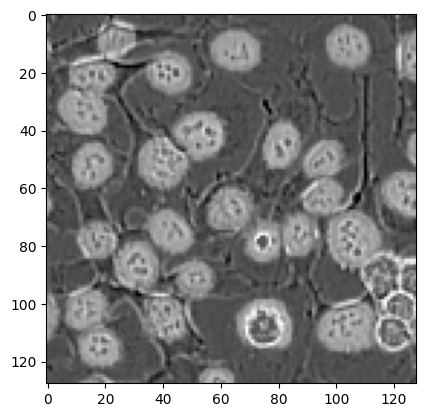

In [ ]:
import matplotlib.pyplot as plt
i = 5
plt.imshow(X[i] / 255 + .5 * y[i],cmap='gray')

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from skimage.measure import label
from skimage import morphology
import pandas as pd

In [ ]:
class CellDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = torch.tensor(image[np.newaxis, :, :].astype(np.float32))
        mask = torch.tensor(mask[np.newaxis, :, :].astype(np.float32))

        return image, mask

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = CellDataset(X_train, y_train)
val_dataset = CellDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
class CC(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.max_pool = nn.MaxPool2d(2)

        self.cc1 = CC(n_channels, 64)
        self.cc2 = CC(64, 128)
        self.cc3 = CC(128, 256)
        self.cc4 = CC(256, 512)
        self.cc5 = CC(512, 1024)
        self.uc1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.uc2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.uc3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.uc4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.cc6 = CC(1024, 512)
        self.cc7 = CC(512, 256)
        self.cc8 = CC(256, 128)
        self.cc9 = CC(128, 64)
        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        o1 = self.cc1(x)
        o2 = self.max_pool(self.cc2(o1))
        o3 = self.max_pool(self.cc3(o2))
        o4 = self.max_pool(self.cc4(o3))
        o5 = self.max_pool(self.cc5(o4))

        u5 = self.uc1(o5)
        x1 = torch.cat([o4, u5], dim=1)
        o6 = self.cc6(x1)

        u4 = self.uc2(o4)
        x2 = torch.cat([o3, u4], dim=1)
        o7 = self.cc7(x2)

        u3 = self.uc3(o3)
        x3 = torch.cat([o2, u3], dim=1)
        o8 = self.cc8(x3)

        u2 = self.uc4(o2)
        x4 = torch.cat([o1, u2], dim=1)
        o9 = self.cc9(x4)

        return self.out(o9)

Epoch 1, Training Loss: 0.5339797043800354, Validation Loss: 0.4718369458402906
Epoch 2, Training Loss: 0.42170583486557006, Validation Loss: 0.38837894797325134
Epoch 3, Training Loss: 0.35658045291900636, Validation Loss: 0.3279463691370828
Epoch 4, Training Loss: 0.3231224203109741, Validation Loss: 0.3087097108364105
Epoch 5, Training Loss: 0.30490102171897887, Validation Loss: 0.2934995932238443
Epoch 6, Training Loss: 0.2914771926403046, Validation Loss: 0.28456853117261616
Epoch 7, Training Loss: 0.2811838459968567, Validation Loss: 0.28186151811054777
Epoch 8, Training Loss: 0.2713211953639984, Validation Loss: 0.2671569117477962
Epoch 9, Training Loss: 0.2625332772731781, Validation Loss: 0.2631149845463889
Epoch 10, Training Loss: 0.2550149405002594, Validation Loss: 0.2869465265955244
Epoch 11, Training Loss: 0.24839543282985688, Validation Loss: 0.2546050527266094
Epoch 12, Training Loss: 0.2420475661754608, Validation Loss: 0.24222108083111898
Epoch 13, Training Loss: 0.23

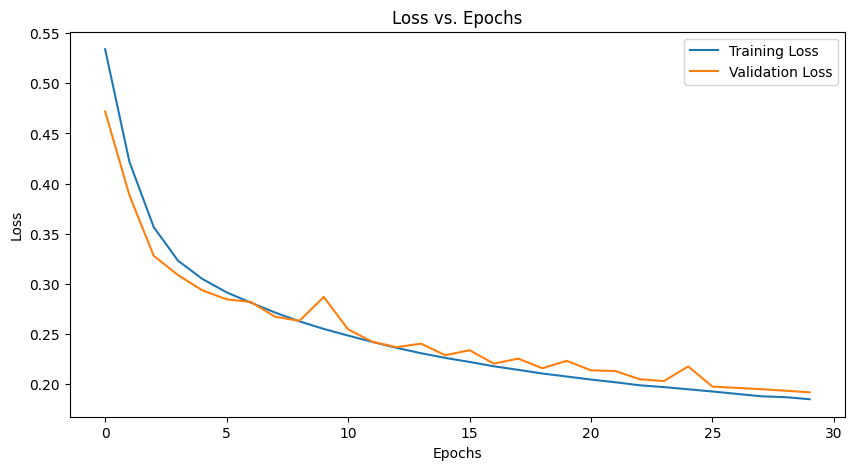

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
model = UNet(n_channels=1, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()

    valid_loss /= len(val_loader)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {valid_loss}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1, Training Loss: 0.5001285743713378, Validation Loss: 0.47334261877196177
Epoch 2, Training Loss: 0.3577774620056152, Validation Loss: 0.3181868706430708
Epoch 3, Training Loss: 0.3010517072677612, Validation Loss: 0.27673024790627615
Epoch 4, Training Loss: 0.27582291603088377, Validation Loss: 0.26871914522988455
Epoch 5, Training Loss: 0.259397132396698, Validation Loss: 0.25677172413894106
Epoch 6, Training Loss: 0.24617818295955657, Validation Loss: 0.23876815821443284
Epoch 7, Training Loss: 0.23632338404655456, Validation Loss: 0.23396665496485575
Epoch 8, Training Loss: 0.22685904324054718, Validation Loss: 0.2259059782539095
Epoch 9, Training Loss: 0.21995727121829986, Validation Loss: 0.22000483955655778
Epoch 10, Training Loss: 0.21315058588981628, Validation Loss: 0.2151755690574646
Epoch 11, Training Loss: 0.20685972571372985, Validation Loss: 0.20872185059956141
Epoch 12, Training Loss: 0.20204635918140412, Validation Loss: 0.20813077049595968
Epoch 13, Training Lo

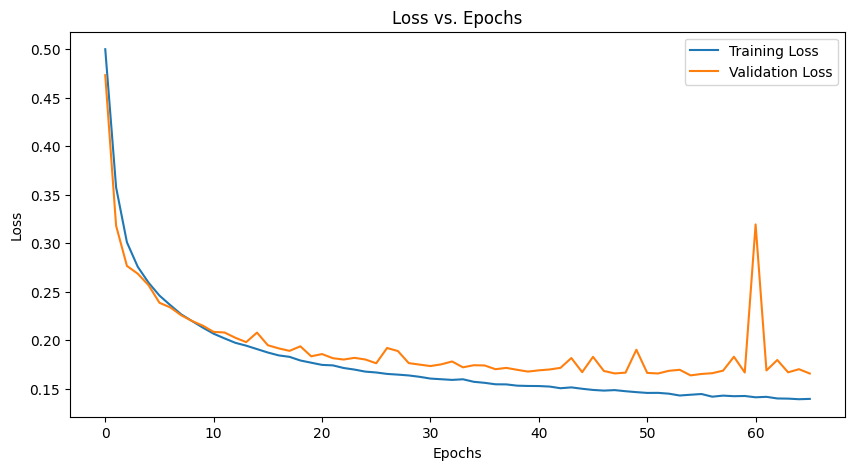

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100
model = UNet(n_channels=1, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
patience = 10
best_loss = np.inf
patience_counter = 0

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()

    valid_loss /= len(val_loader)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {valid_loss}')

    if valid_loss < best_loss:
        best_loss = valid_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter > patience:
        break

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from skimage.measure import label
from skimage import morphology

In [ ]:
min_mae = np.inf
with torch.no_grad():
    for r in [0.95, 0.99, 0.995, 0.999]:
        for min_size in [1, 2, 3, 5, 7, 10, 20]:
            s = 0
            for data, y in val_loader:
                data = data.to(device)
                output = model(data)
                output = torch.sigmoid(output)
                output = output.cpu().numpy()
                for i in range(len(y)):
                    prediction_bin = (output[i] > r).astype(np.uint8).astype(bool)
                    prediction_bin = morphology.remove_small_objects(prediction_bin, min_size=min_size)
                    pred_labeled_img = label(prediction_bin)
                    labeled_img = label(y[i])
                    s += np.abs(np.max(pred_labeled_img) - np.max(labeled_img))
            mae = s / len(val_dataset)
            if mae < min_mae:
                min_mae = mae
                best_r = r
                best_min_size = min_size
            print(r, min_size, mae)

0.95 1 1.95
0.95 2 1.8175
0.95 3 1.9275
0.95 5 2.2275
0.95 7 2.495
0.95 10 2.8325
0.95 20 3.7975
0.99 1 2.3875
0.99 2 2.88
0.99 3 3.2775
0.99 5 3.8325
0.99 7 4.2975
0.99 10 4.9025
0.99 20 6.6425
0.995 1 2.9025
0.995 2 3.685
0.995 3 4.22
0.995 5 4.915
0.995 7 5.5825
0.995 10 6.375
0.995 20 8.645
0.999 1 6.3425
0.999 2 7.725
0.999 3 8.5825
0.999 5 9.7
0.999 7 10.7
0.999 10 11.875
0.999 20 14.8075


In [ ]:
npzfile = np.load('test_images.npz')
X = npzfile['X']

In [ ]:
test_loader = DataLoader(X, batch_size=1, shuffle=False)

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data[np.newaxis, :, :, :]
        data = data.to(device)
        output = model(data)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()
        predictions.append(output[0])

In [ ]:
cell_counts = []

for prediction in predictions:
    prediction_bin = (prediction > best_r).astype(np.uint8)
    prediction_bin = morphology.remove_small_objects(prediction_bin, min_size=best_min_size)
    labeled_img = label(prediction_bin)
    cell_count = np.max(labeled_img)
    cell_counts.append(cell_count)

print(cell_counts)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


[3, 12, 11, 10, 14, 16, 19, 24, 20, 9, 8, 13, 17, 17, 23, 19, 29, 31, 30, 27, 24, 17, 11, 21, 31, 34, 27, 27, 34, 38, 28, 39, 27, 9, 7, 12, 15, 21, 23, 25, 22, 28, 12, 13, 11, 12, 15, 16, 32, 38, 32, 31, 34, 40, 33, 8, 7, 11, 11, 16, 16, 23, 23, 14, 13, 12, 12, 18, 18, 22, 21, 25, 22, 25, 16, 25, 18, 13, 10, 8, 14, 11, 10, 17, 19, 13, 10, 8, 8, 19, 17, 18, 21, 22, 26, 20, 24, 23, 21, 12, 12, 9, 16, 16, 19, 17, 9, 15, 17, 13, 13, 19, 16, 22, 21, 21, 27, 22, 24, 14, 17, 11, 19, 20, 20, 18, 20, 16, 15, 9, 10, 8, 18, 21, 26, 18, 24, 25, 22, 31, 33, 31, 21, 22, 26, 34, 30, 40, 32, 28, 32, 30, 27, 24, 20, 18, 23, 25, 27, 29, 34, 52, 46, 44, 36, 25, 35, 19, 28, 32, 24, 22, 20, 18, 24, 22, 22, 29, 29, 36, 34, 34, 32, 34, 30, 29, 15, 22, 21, 25, 28, 32, 32, 39, 45, 57, 44, 36, 5, 4, 5, 11, 12, 13, 17, 17, 10, 18, 17, 8, 5, 7, 11, 16, 20, 16, 17, 20, 13, 10, 11, 10, 15, 20, 26, 23, 23, 31, 30, 28, 24, 37, 23, 43, 52, 38, 44, 36, 37, 41, 41, 28, 5, 14, 7, 16, 21, 18, 18, 18, 16, 17, 15, 18, 17, 1

In [ ]:
import pandas as pd
result = pd.DataFrame({'index':range(2000),'count':cell_counts})

In [ ]:
result.to_csv('submission.csv', index=None)